In [ ]:
""" 
INSTRUÇÕES:
objetivo geral: criar uma rede neural para classificação de imagens do dataset 
fashion mnist e exploração de todas as características da rede neural, uma por vez.

O melhor resultado de cada questão/etapa é utilizado nas próximas 
QUESTÃO 01: exploração inicial 
    Dataset fashion mnist
    função de ativação
    5 testes com inicialização aleatória: diferenças de convergencia, estabilidade e desempenho
    dataset de treino
    métricas: medida de desempenho(accuracy), função de perda (entropia cruzada/loss), curva de convergência
    otimizador: Adam
    arquitetura: quantas camadas e neurônios por camada
    funcoes de ativação: ReLU, Sigmoid ou Tanh
    quantas épocas
    taxa de aprendizado
    indícios de under/overfitting

QUESTÃO 02: exploração de hiperparâmetros
    taxa de aprendizado x termo momento x velocidade de convergência
    Grid search para encontrar a melhor combinação: erro de treinamento x taxa de aprendizado x momento
    taxa de aprendizado menor e momento intermediário
    dataset de treino e (opcionalmente) dataset de validação
    métricas: função de perda, velocidade de convergência, curva de convergência e (opcional) estabilidade
    critério de parada 
    combinação com melhor equilíbrio entre velocidadee estabilidade
    tendências observadas(ex: maior taxa de aprendizado leva a maior velocidade, mas menor estabilidade)

QUESTÃO 03: topologia de rede neural
    dataset de treino e (opcionalmente) dataset de validação
    impacto do número de camadas ocultas e neurônios por camada e teste de variação desses números
    métricas: função de perda, curva de convergência(under e overfitting), tempo de treinamento, generalização(medida F), precisão, revocação
    gráfico de perda mostrando diferença entre topologias
    
QUESTÃO 04: qualidade dos dados
    influência do número e qualidade dos dados, ruído, etc sobre a capacidade de generalização
    dividir o dataset em subsets de acordo com o rótulo -> manter proporcionalidade
    faixas do dataset: 10%, 30%, 50%, 70%, 100%
    métrica: função de perda, acurácia, 
    identificar saturação no aprendizado
    curvas de generalização: tamanho do conjunto X desempenho
    tempo de treinamento e custo computacional
    Estratégia de amostragem(estratificada, aleatória ou outra)

QUESTÃO 05:
    escolher 4 melhores modelos e usar modelo de testes neles
    treinamento como referência comparativa
    ajustes de otimização
    métricas: perda(entropia cruzada categórica), acurácia, curva de validação(treinamento x teste), F1 score, precisão, revocação
    escolha da configuração final do modelo

QUESTÃO 06: validação cruzada k-fold
    divisão do dataset em k-subconjuntos e teste em todos eles
    métricas: média de todas as partições de perda: acurácia e F1. 
    para cada partição: curvas de validação e variância(dispersão) dos resultados 
    justificativa do tamanho de k
    identificação de flutuações
"""

# Passo inicial: carregar e visualizar o Fashion-MNIST
- Objetivo: confirmar acesso ao dataset e entender suas classes.
- A seguir: carregamos via `tensorflow.keras.datasets.fashion_mnist` e mostramos algumas imagens com seus rótulos.

Treino: (60000, 28, 28), Teste: (10000, 28, 28)
Exemplo de rótulos (0-9): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


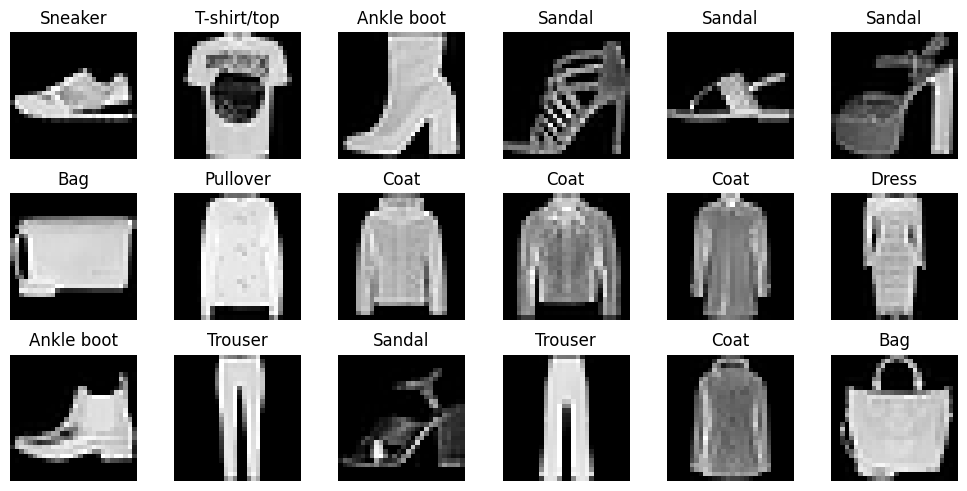

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Treino: {x_train.shape}, Teste: {x_test.shape}")
print("Exemplo de rótulos (0-9):", labels)

# Normalização (0-1) para visualização e futura modelagem
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

# Grid de amostras
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0, len(x_train))
    ax.imshow(x_train[idx], cmap="gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Próximos passos para a Questão 01
- Definir arquitetura inicial (camadas/neurônios).
- Escolher função de ativação (ReLU, Sigmoid ou Tanh).
- Otimizador: `Adam`, métricas: acurácia e perda (entropia cruzada).
- Executar 5 treinos com inicialização aleatória e comparar convergência/estabilidade/desempenho.

# Questão 01: Rede neural simples (ReLU, Adam, accuracy, entropia cruzada)
- Modelo leve com poucas camadas/neurônios.
- 5 execuções com seeds diferentes para comparar convergência/estabilidade.
- Métricas: perda (entropia cruzada) e acurácia; curvas de treinamento/validação.

Seeds geradas (espacadas): [466763261, 465103144, 463447406, 461803732, 460147934]
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7975 - loss: 0.6028
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7975 - loss: 0.6028
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8515 - loss: 0.4229
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8515 - loss: 0.4229
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8640 - loss: 0.3864
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8640 - loss: 0.3864
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8716 - loss: 0.3624
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8716 - loss: 0.3624
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8769 - loss: 0.3434
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8769 - loss: 0.3434
Epoch 1/5
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.80

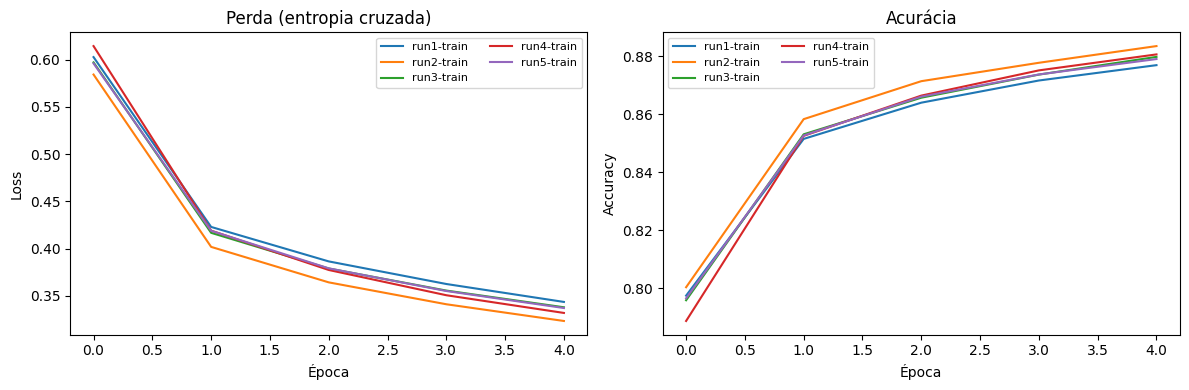

Teste - Loss: 0.3972, Accuracy: 0.8607
Seeds usadas:
466763261
465103144
463447406
461803732
460147934


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import secrets

# Reusa dados carregados anteriormente: x_train, y_train, x_test, y_test
# Ajusta forma para camadas Conv2D (opcional) ou usa Flatten direto
X = x_train
Y = y_train

# Split treino/validação
#X_train, X_val, y_train_, y_val_ = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) #20% do treino vira validação. stratify=Y mantém a proporção das classes

def build_model():
    model = keras.Sequential([ #modelo sequencial -> "clássico" com uma camada após a outra
        keras.layers.InputLayer(shape=(28, 28)), #imagens 28x28 pixels, cada pixel é um neurônio de entrada
        keras.layers.Flatten(), #transforma matriz 2D 28x28 em vetor 1D com 784 elementos
        keras.layers.Dense(64, activation='relu'), #ReLu como função de ativação não linear. 64 neurônios
        keras.layers.Dense(32, activation='relu'), #2 camadas ocultas para reduzir overfitting
        keras.layers.Dense(10, activation='softmax') #10 saídas(classes) possíveis. softmax normaliza saídas para somarem 1.
        #No cenário ideal, o neurônio de saída correspondente à classe correta terá saída 1, e os demais, 0.
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(), #aprendizado adaptativo
        loss='sparse_categorical_crossentropy', #ideal para classificação multiclasse com rótulos inteiros
        metrics=['accuracy'] #medida de desempenho simples
    )
    return model

# ===== Método para "espaçar" mais as seeds =====
# Ideia: usar uma base aleatória de 32 bits e aplicar um incremento grande e primo
# (ex: 2654435761 = constante de Knuth) gerando progressão pseudo-dispersada em 32 bits.
# Depois aplicamos uma mistura (hash simples) para minimizar correlação linear.

histories = []
PRIME_STEP = 2654435761  # grande e usado em hashing
MASK32 = 0xFFFFFFFF
base = secrets.randbits(32)

#método para gerar seeds espaçadas e contrastantes
def spaced_seeds(n, base_seed, step):
    seeds = []
    for i in range(n):
        raw = (base_seed + i * step) & MASK32
        # Mistura extra: multiplicação + xor + shift (barato, evita sequência muito próxima)
        mixed = (raw * 0x9E3779B1) & MASK32
        mixed ^= (mixed >> 16)
        seeds.append(mixed)
    return seeds

seeds = spaced_seeds(5, base, PRIME_STEP)
print("Seeds geradas (espacadas):", seeds)

histories = []
for seed in seeds:
    keras.utils.set_random_seed(seed) #inicialização de pesos aleatórios, embaralhamento e escolha aleatória de índices
    model = build_model()
    h = model.fit(
        X, Y,
        #validation_data=(X_val, y_val_),
        #ou validation_split=0.2,
        epochs=5,
        batch_size=128,
        verbose=1 #se for 1, mostra a barra de progresso em cada época
    )
    histories.append(h)

# Plot das curvas de perda e acurácia para as 5 execuções
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, h in enumerate(histories, start=1):
    axes[0].plot(h.history['loss'], label=f'run{i}-train')
    #axes[0].plot(h.history['val_loss'], linestyle='--', label=f'run{i}-val')
axes[0].set_title('Perda (entropia cruzada)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend(ncol=2, fontsize=8)

for i, h in enumerate(histories, start=1):
    axes[1].plot(h.history['accuracy'], label=f'run{i}-train')
    #axes[1].plot(h.history['val_accuracy'], linestyle='--', label=f'run{i}-val')
axes[1].set_title('Acurácia')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Avaliação final no conjunto de teste (último modelo)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Teste - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print("Seeds usadas:")
for s in seeds:
    print(s)
# Guarde estas seeds se quiser repetir resultados futuros.